### What does Logistic Regression do?

#### Logistic Regression:

*   Solves binary and multi-class classification problems by determining the best boundaries between classes.
*   Fits a line through our data and tries to maximize the number of correct data points on either side of the line

### How does Logistic Regression work?

We'll go through the explanation for this algorithm with our recipe example.

#### The data

We just have two dishes, $x\_1$ and $x\_2$. They are each japanese and italian dishes respectively, and we have indicated their ingredient features with `0`'s and `1`'s.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-PY0181EN-SkillsNetwork/labs/2_linear_classifiers/images/Data.png" alt="drawing" width="500">

#### Step 1

Imagine we have already trained our binary logistic regressor, and the *$Parameters$* have already been determined. Each $\beta$ represents a parameter we have trained.

We will now plug in the features from our two dishes into the regression equation $f(x)$ which is the **sum** of the **product** of our inputs and parameters.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-PY0181EN-SkillsNetwork/labs/2_linear_classifiers/images/step1.png" alt="drawing" width="500">

#### Step 2

This is the important part! We now plug in the previous result into the logit function which will spit out a value between 0 and 1. This value can be interpreted as a probability of either class.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-PY0181EN-SkillsNetwork/labs/2_linear_classifiers/images/step2.png" alt="drawing" width="500">

#### Visualization

Here we visualize our results. Our two dishes, after being run through logistic regression, have been mapped onto a logit function with their $y$ values signifying how much they belong to either class. The further right you go, the more Italian the dish and vice versa.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-PY0181EN-SkillsNetwork/labs/2_linear_classifiers/images/visualization.png" alt="drawing" width="500">

### All together

Here is the big picture:

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-PY0181EN-SkillsNetwork/labs/2_linear_classifiers/images/summary.png" alt="drawing" width="1150">
<!-- ![Diagram](Picture1.png){ width : 50% } -->


In [3]:
from tqdm import tqdm
import json
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import accuracy_score

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [ ]:
#data_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-PY0181EN-SkillsNetwork/labs/2_linear_classifiers/data/data.json"
#raw_data = await skillsnetwork.read(data_url)
#data = json.loads(raw_data)
#df = pd.DataFrame(data).set_index("id")

In [4]:
import pandas as pd
import json
import requests

# Replace with the actual data URL
data_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-PY0181EN-SkillsNetwork/labs/2_linear_classifiers/data/data.json"

# Use requests.get to download the JSON data
response = requests.get(data_url)

# Check for successful download (status code 200)
if response.status_code == 200:
  # Load the JSON data using json.loads
  data = json.loads(response.text)
  # Create the DataFrame and set index
  df = pd.DataFrame(data).set_index("id")
else:
  print(f"Error downloading data: {response.status_code}")

# Use the DataFrame 'df' for further processing


In [6]:
df.shape

(39774, 2)

Let's look at some samples rows from the dataset we loaded:

In [8]:
df.sample(5)

,cuisine,ingredients
id,,
44713,indian,"[tomatoes, buttermilk, chopped onion, chopped ..."
34169,italian,"[dough, Italian parsley leaves, ground black p..."
11553,mexican,"[reduced fat monterey jack cheese, lettuce lea..."
31955,indian,"[tumeric, extra firm tofu, green peas, ground ..."
48677,southern_us,"[soft-wheat flour, almond extract, milk, vanil..."


**As you can see, each dish has a whole list of ingredients associated with it. We need to process them somehow in order to plug them into our logistic regression function, which will help us classify each dish into their cuisines.**

Lets also look at the distribution of cuisines:

In [10]:
df["cuisine"].unique().tolist()

['greek',
 'southern_us',
 'filipino',
 'indian',
 'jamaican',
 'spanish',
 'italian',
 'mexican',
 'chinese',
 'british',
 'thai',
 'vietnamese',
 'cajun_creole',
 'brazilian',
 'french',
 'japanese',
 'irish',
 'korean',
 'moroccan',
 'russian']

In [11]:
len(df["cuisine"].unique())

20

<AxesSubplot:>

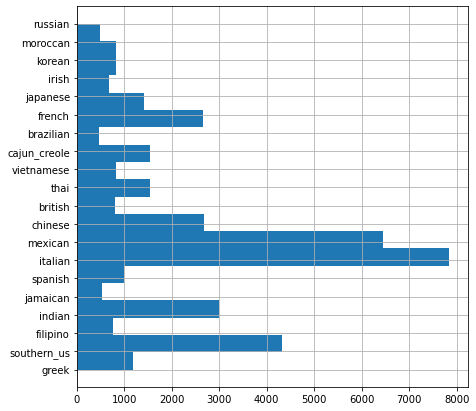

In [12]:
df["cuisine"].hist(orientation='horizontal', bins=20, figsize=(7,7))

Now, **lets think about how we can use ingredients to represent a dish.** You may immediately think to just use the names of the ingredients to represent a dish. Before we do that, lets analyze the ingredients.

Here we can see a histogram that describes the frequency of each ingredient list length. We see that the mean ingredient list length is around 10, with the max close to 30.

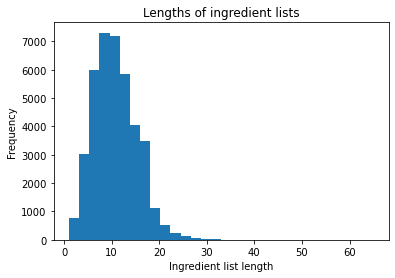

In [13]:
plt.hist(df['ingredients'].apply(lambda x: len(x)), bins = 30)
plt.title("Lengths of ingredient lists")
plt.xlabel("Ingredient list length")
plt.ylabel("Frequency")
plt.show()

If we created a matrix where every ingredient was one column, and all it did was signify if that ingredient was in a given dish, how many columns would we have?

**We can use the `pd.Series.explode()` method on the `ingredients` column to merge the lists of ingredients into one large pandas Series of all the ingredients.**

This list contains all the ingredients from every recipe, but thats not helpful because we have duplicates such as `garlic` and many others. If we perform a `pd.Series.unique()` we can eliminate all the duplicates.

In [15]:
all_ingredients = df['ingredients'].explode()
all_ingredients

id
10259    romaine lettuce
10259       black olives
10259     grape tomatoes
10259             garlic
10259             pepper
              ...       
2362              garlic
2362         white sugar
2362       roma tomatoes
2362              celery
2362       dried oregano
Name: ingredients, Length: 428275, dtype: object

In [16]:
ingredients = all_ingredients.unique()
len(ingredients)

6714

Thats a lot of ingredients; if we had `6714` columns for `39774` rows of data, then we'd have a matrix of `267,042,636` cells! That's way too large. We need a way to extract important information without bogging down our system with a crazy amount of computations.

### Enter NLP: Dish Embeddings

Since we're working with text, a simple and easy thing to do is to is to merge the ingredient list of each dish into a string, and use the words in that string to represent the dish. This will give us a quick and easy understanding of what ingredients go into a dish.

This representation of a dish by the count of each ingredient is referred to as a **embedding**. We are creating an **embedding/mapping** of a data point using it's words/ingredients in an $n$ dimensional space.

To do this, we'll be using the `CountVectorizer` sklearn method.

```python
CountVectorizer(*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>)
```

In [17]:
# Inggredients from the first dish in training data
df.loc[0,'ingredients']

['mussels',
 'ground black pepper',
 'garlic cloves',
 'saffron threads',
 'olive oil',
 'stewed tomatoes',
 'arborio rice',
 'minced onion',
 'medium shrimp',
 'fat free less sodium chicken broth',
 'green peas']

In [18]:
# Converted the list into one string
df['ingredients'].astype(str)[0].strip('[]')

"'mussels', 'ground black pepper', 'garlic cloves', 'saffron threads', 'olive oil', 'stewed tomatoes', 'arborio rice', 'minced onion', 'medium shrimp', 'fat free less sodium chicken broth', 'green peas'"

Looks like a good, detailed list of ingredients! One concern we may have is how detailed we want our ingredients to be. Does specifying `'fat free less sodium chicken broth'` provide more information over a simpler term such as `'chicken broth'`?

#### How to solve

We can use the `ngram_range` argument to limit the number of words in a given ingredient. If we set it to `(1,2)`, then our `CountVectorizer` will look at only one to two words at a time such as `chicken` and `chicken broth`, but not `fat free less sodium chicken broth`.

##### Caveat

This may mean that terms such as `fat free` or `less sodium` will become "ingredients", but will be largely meaningless. This can be ignored, as we will be selecting the top features by their freqeuncy through all recipes.


In [19]:
#grab the training set ingredients
ingredients = df['ingredients'].astype(str).apply(lambda x: x.strip('[]'))

cv = CountVectorizer(ngram_range=(1,2), max_features=200)
tf = cv.fit_transform(ingredients)

df_vectorized = pd.DataFrame(tf.toarray(), columns=cv.get_feature_names_out())
df_vectorized

,all,all purpose,avocado,baking,baking powder,basil,bay,beans,beef,bell,...,vegetable oil,vinegar,virgin,virgin olive,water,white,white wine,whole,wine,yellow
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39769,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,1,0,0
39770,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39771,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39772,0,0,0,2,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0


In [20]:
# Lets just look at the top 10
cv.get_feature_names_out()[:10]

array(['all', 'all purpose', 'avocado', 'baking', 'baking powder',
       'basil', 'bay', 'beans', 'beef', 'bell'], dtype=object)

In [21]:
# I've taken the liberty of removing these features,
# although you can add or remove features to this list as you see fit!

excludedWords = ['all', 'all purpose', 'baking', 'brown', 'cooked', 'cooking', 'diced', 'dried', 'dry',
                 'extra', 'extra virgin', 'extract', 'grated', 'green', 'ground', 'heavy', 'hot', 
                 'italian', 'kosher', 'large', 'low', 'minced', 'light', 'powder', 'purple', 'purpose',
                 'purpose flour', 'red', 'sea', 'skinless', 'sliced', 'sodium chicken','sour','unsalted',
                 'virgin', 'white','whole','yellow']

### Note on excluding features

When you work with text data, especially word embeddings, it generally is not recommended to manually remove features in this fashion as it is subjective and not reproduceable. With the appropriate reasoning however it could be acceptable.

In [22]:
df_vectorized.drop(columns=excludedWords, inplace=True)

In [23]:
df_vectorized.head()

,avocado,baking powder,basil,bay,beans,beef,bell,bell pepper,black,black pepper,...,unsalted butter,vanilla,vanilla extract,vegetable,vegetable oil,vinegar,virgin olive,water,white wine,wine
0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,1,...,0,0,0,1,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0
4,0,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0


Using this dataset, we can now apply **Logistic Regression**.


### Note on embeddings

WHat we have here is a very simple term frequency matrix. As it is essentially one hot encoded, it is very simple compared to term frequency matrices for other NLP topics.

Another popular matrix to use in NLP is the **tf-idf** matrix, which stands for the **term frequency - inverse document freqeuncy** matrix. This matrix augments the terms in the term frequency matrix such that more *important/special* words to a given document have higher values than words that just occur alot, such as *"the", or "and"*. Using this matrix, you can create more meaningful document embeddings, which may help in various applications that require accurate representations of documents.

### Exercise 1 - Prepare the data

Now above we have the DataFrame all prepared, we need to split it into training and testing data. We'll be using the `train_test_split` function from sklearn.

```python
train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)

#Example
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.33, random_state=42)
...
>>> X_train
array([[4, 5],
       [0, 1],
       [6, 7]])
>>> y_train
[2, 0, 3]
>>> X_test
array([[2, 3],
       [8, 9]])
>>> y_test
[1, 4]
```

We'll be using the `stratify` parameter to stratify our data, because we have an inbalanced dataset with a large number of Mexican dishes/datapoints.


In [28]:
 #TODO: Use the train_test_split() function twice in order to split the data into 75% training and 25% testing data
x_train, x_test, y_train, y_test = train_test_split(df_vectorized, df['cuisine'], test_size=0.25, random_state=1, stratify=df['cuisine'])

In [29]:

x_train, x_test, y_train, y_test = train_test_split(df_vectorized, df['cuisine'], test_size=0.25, random_state=1, stratify=df['cuisine'])

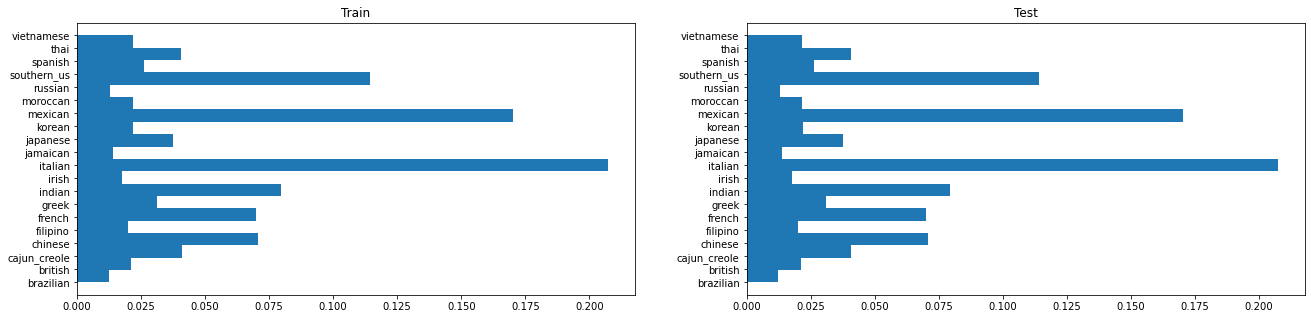

In [30]:
fig, ax = plt.subplots(1, 2,figsize=(22,5))

ax[0].hist(y_train.sort_values(),orientation='horizontal', bins=20, density=True)
ax[1].hist(y_test.sort_values(),orientation='horizontal', bins=20, density=True)
ax[0].set_title('Train')
ax[1].set_title('Test')
fig.show()

We'll be using the sci-kit learn package to implement [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMPY0181ENSkillsNetwork36484875-2022-01-01). Make sure to use the `multi_class="multinomial"` argument.

```python
LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

#Example
>>> lr = LogisticRegression(random_state=0).fit(X, y)

>>> y_true = [0, 1, 2, 2, 2]
>>> y_pred = lr.predict(x_test)
>>> print(classification_report(y_true, y_pred, target_names=target_names))
```


In [31]:
lr = LogisticRegression(multi_class="multinomial").fit(x_train, y_train)
print(classification_report(y_test, lr.predict(x_test)))

              precision    recall  f1-score   support

   brazilian       0.49      0.27      0.35       117
     british       0.36      0.17      0.23       201
cajun_creole       0.72      0.59      0.65       386
     chinese       0.71      0.78      0.74       668
    filipino       0.60      0.44      0.51       189
      french       0.47      0.46      0.47       662
       greek       0.61      0.41      0.49       294
      indian       0.79      0.78      0.78       751
       irish       0.51      0.31      0.38       167
     italian       0.67      0.80      0.73      1960
    jamaican       0.65      0.44      0.53       131
    japanese       0.51      0.43      0.47       356
      korean       0.74      0.66      0.70       207
     mexican       0.84      0.86      0.85      1610
    moroccan       0.70      0.65      0.68       205
     russian       0.53      0.29      0.37       122
 southern_us       0.48      0.63      0.55      1080
     spanish       0.46    

<AxesSubplot:>

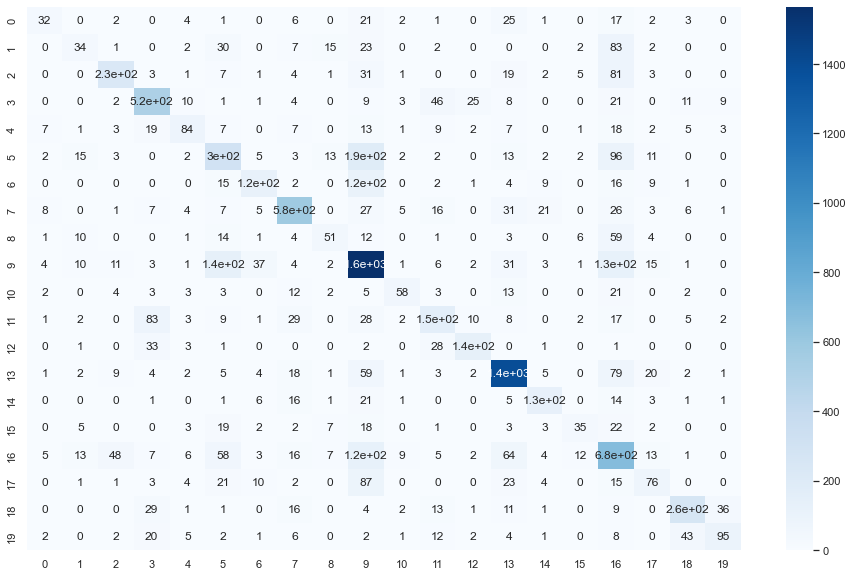

In [32]:
conf_mat = confusion_matrix(y_test, lr.predict(x_test))
sns.set(rc = {'figure.figsize':(16,10)})
sns.heatmap(conf_mat, annot=True, cmap="Blues")

### Question:

Results are kinda lackluster...what can we do?

<details>
    <summary>Click here for possible solutions</summary>
    <ol>
        <li>Implementing cross validation</li>
        <li>Increase the amount of features!</li>
        <li>Playing with Count Vectorizer feature ngram sizes</li>
        <li>Reduce dimensionality of feature matrix while increasing amount of features</li>
        <li>Playing with training/testing set sizes</li>
    </ol>
</details>

    <ol>
        <li>Implementing cross validation</li>
        <li>Increase the amount of features!</li>
        <li>Playing with Count Vectorizer feature ngram sizes</li>
        <li>Reduce dimensionality of feature matrix while increasing amount of features</li>
        <li>Playing with training/testing set sizes</li>
    </ol>

### Option 1: Implementing Cross Validation

Cross validation is the practice of taking a random set from within the training data and using it to optimize the algorithm. This improves it's ability to generalize (perform well when given new data)

![CV-Example](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-PY0181EN-SkillsNetwork/labs/2_linear_classifiers/images/K-fold_cross_validation.svg)

By Gufosowa - Own work, CC BY-SA 4.0, [https://commons.wikimedia.org/w/index.php?curid=82298768](https://commons.wikimedia.org/w/index.php?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMPY0181ENSkillsNetwork36484875-2022-01-01&curid=82298768)

Here, we'll use 5 folds but you can use as many or as little as you like.

In [37]:
# TAKES A WHILE

lr_cv = LogisticRegressionCV(cv=5).fit(x_train, y_train)

In [38]:
print(classification_report(y_test, lr_cv.predict(x_test)))

              precision    recall  f1-score   support

   brazilian       0.57      0.26      0.36       117
     british       0.36      0.16      0.22       201
cajun_creole       0.73      0.59      0.65       386
     chinese       0.71      0.78      0.74       668
    filipino       0.63      0.43      0.51       189
      french       0.47      0.47      0.47       662
       greek       0.61      0.40      0.49       294
      indian       0.79      0.78      0.79       751
       irish       0.54      0.31      0.39       167
     italian       0.67      0.80      0.73      1960
    jamaican       0.70      0.44      0.54       131
    japanese       0.51      0.44      0.47       356
      korean       0.77      0.68      0.72       207
     mexican       0.84      0.87      0.85      1610
    moroccan       0.71      0.63      0.67       205
     russian       0.57      0.28      0.37       122
 southern_us       0.48      0.64      0.55      1080
     spanish       0.46    

<AxesSubplot:>

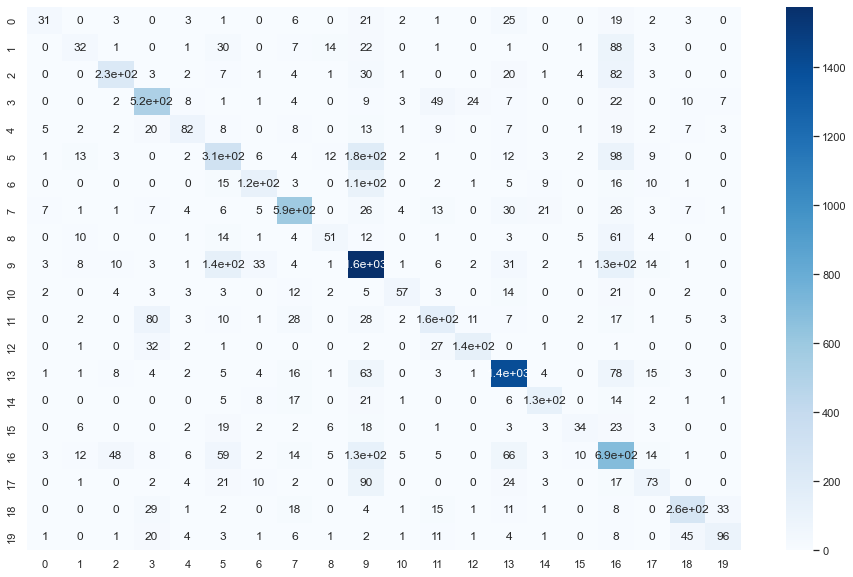

In [39]:
conf_mat = confusion_matrix(y_test, lr_cv.predict(x_test))
sns.set(rc = {'figure.figsize':(16,10)})
sns.heatmap(conf_mat, annot=True, cmap="Blues")

In [40]:
print(classification_report(y_test, lr_cv.predict(x_test)))

              precision    recall  f1-score   support

   brazilian       0.57      0.26      0.36       117
     british       0.36      0.16      0.22       201
cajun_creole       0.73      0.59      0.65       386
     chinese       0.71      0.78      0.74       668
    filipino       0.63      0.43      0.51       189
      french       0.47      0.47      0.47       662
       greek       0.61      0.40      0.49       294
      indian       0.79      0.78      0.79       751
       irish       0.54      0.31      0.39       167
     italian       0.67      0.80      0.73      1960
    jamaican       0.70      0.44      0.54       131
    japanese       0.51      0.44      0.47       356
      korean       0.77      0.68      0.72       207
     mexican       0.84      0.87      0.85      1610
    moroccan       0.71      0.63      0.67       205
     russian       0.57      0.28      0.37       122
 southern_us       0.48      0.64      0.55      1080
     spanish       0.46    

## Option 2: Increase the amount of features!
If you recall, we originally asked the count vectorizer to use the top 200 features (ingredients/terms) from our recipes. Here, we'll ask for more, lets say 1000.

In [42]:
# Increase the number of features
cv_lg = CountVectorizer(ngram_range=(1,2), max_features=1000)
tf_lg = cv_lg.fit_transform(ingredients)
df_lg = pd.DataFrame(tf_lg.toarray(), columns=cv_lg.get_feature_names_out())
x_train_lg, x_test_lg, y_train_lg, y_test_lg = train_test_split(df_lg, df['cuisine'], test_size=0.25, random_state=1, stratify=df['cuisine'])

# Fit to the Logistic Regression model
lr_cv_lg = LogisticRegression().fit(x_train_lg, y_train_lg)

# Print results
print(classification_report(y_test_lg, lr_cv_lg.predict(x_test_lg)))

              precision    recall  f1-score   support

   brazilian       0.55      0.53      0.54       117
     british       0.46      0.35      0.40       201
cajun_creole       0.75      0.69      0.72       386
     chinese       0.76      0.83      0.79       668
    filipino       0.64      0.53      0.58       189
      french       0.51      0.57      0.54       662
       greek       0.69      0.67      0.68       294
      indian       0.85      0.85      0.85       751
       irish       0.53      0.47      0.50       167
     italian       0.78      0.84      0.81      1960
    jamaican       0.76      0.60      0.67       131
    japanese       0.67      0.61      0.64       356
      korean       0.80      0.77      0.79       207
     mexican       0.88      0.90      0.89      1610
    moroccan       0.75      0.67      0.71       205
     russian       0.66      0.48      0.56       122
 southern_us       0.68      0.71      0.69      1080
     spanish       0.55    

<AxesSubplot:>

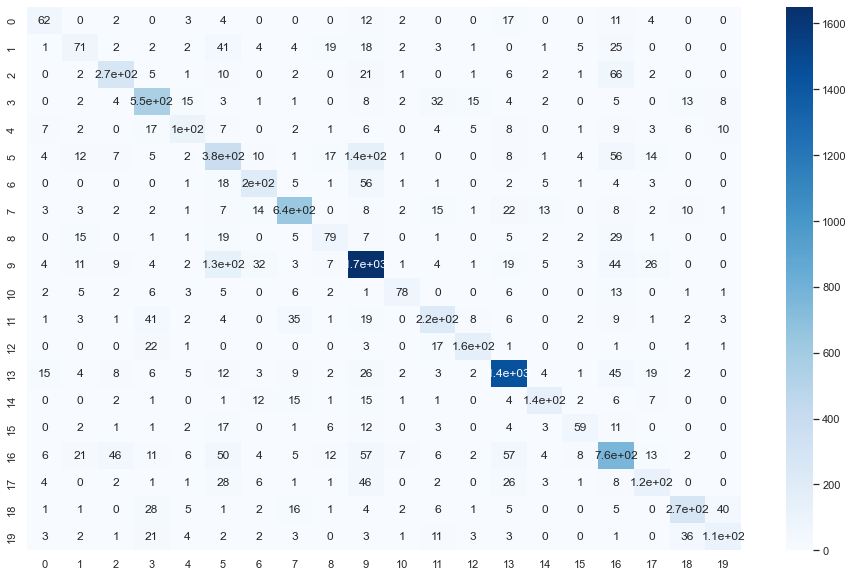

In [43]:
conf_mat = confusion_matrix(y_test_lg, lr_cv_lg.predict(x_test_lg))
sns.set(rc = {'figure.figsize':(16,10)})
sns.heatmap(conf_mat, annot=True, cmap="Blues")

### Option 3: Playing with Count Vectorizer feature ngram sizes

Do you remember how we asked the Count Vectorizer to give us features which were 1 to 2 words long using the `ngram_range` argument? If we were to adjust this, perhaps it could help. Lets take a look.

Instead of using features/terms with 1 or 2 words like `"flour"`, `"wild rice"` or `"bell pepper"`, we will only have features of one word like `"flour"`, `"rice"` and `"pepper"`.

In [44]:
# TAKES A VERY LONG WHILE

# We adjusted the size of our features using the ngram_range argument
cv_lg_oneword = CountVectorizer(ngram_range=(1,1), max_features=1000)
tf = cv_lg_oneword.fit_transform(ingredients)

df_oneword = pd.DataFrame(tf.toarray(), columns=cv_lg_oneword.get_feature_names_out())
df_oneword

x_train, x_test, y_train, y_test = train_test_split(df_oneword, df['cuisine'], test_size=0.25, random_state=1, stratify=df['cuisine'])
lr_cv = LogisticRegression().fit(x_train, y_train)

print(classification_report(y_test, lr_cv.predict(x_test)))

              precision    recall  f1-score   support

   brazilian       0.66      0.56      0.61       117
     british       0.57      0.43      0.49       201
cajun_creole       0.78      0.71      0.74       386
     chinese       0.77      0.85      0.81       668
    filipino       0.69      0.58      0.63       189
      french       0.58      0.64      0.61       662
       greek       0.72      0.73      0.72       294
      indian       0.85      0.86      0.86       751
       irish       0.64      0.58      0.61       167
     italian       0.80      0.87      0.84      1960
    jamaican       0.81      0.67      0.74       131
    japanese       0.75      0.66      0.70       356
      korean       0.82      0.81      0.82       207
     mexican       0.89      0.91      0.90      1610
    moroccan       0.82      0.70      0.76       205
     russian       0.68      0.54      0.60       122
 southern_us       0.72      0.76      0.74      1080
     spanish       0.59    

<AxesSubplot:>

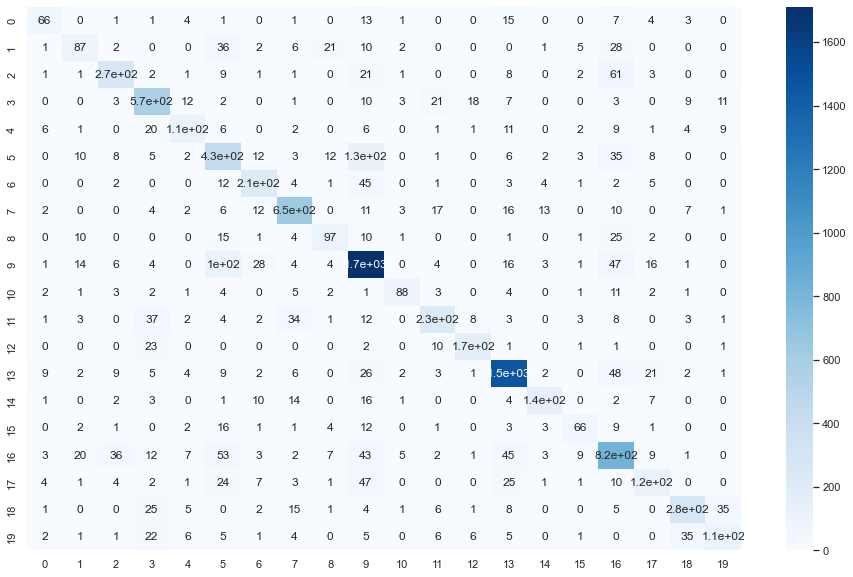

In [45]:
conf_mat = confusion_matrix(y_test, lr_cv.predict(x_test))
sns.set(rc = {'figure.figsize':(16,10)})
sns.heatmap(conf_mat, annot=True, cmap="Blues")

It seems like reducing our input features to just singular words actually improved accuracy slightly!

### Option 4: Reduce dimensionality with increased features
Now by reduce dimensionality, we mean to reduce the number of features (columns) of our data down. This may seem coutner intuitive, why would we want to reduce the number of features, when they provide us with more information and help increase our accuracy?

**Answer: There are special techniques for reducing dimensionality, such as Principle Component Analysis (PCA), Singular Value Decomposition (SVD) and Non-Negative Matrix Factorization (NNMF). These methods will simultaneously reduce the number of features, while still preserving the important information from them! Its like compressing a large video that you took in order to post it to YouTube; it may not be super crisp but it'll still have all the important information.**

Another reason why we want to reduce dimensionality is speed. If you actually took the time to run the cell above, you'd realize that it takes a loooooong time. In practice, not only will this delay your work but its costly to run and maintain into the future.

In this lab, we'll use PCA and SVD to reduce dimensionality. The details aren't important as in this lab we are focusing on the classification task and method of improvement. You can learn more these algorithms in IBM courses!

In [47]:
# We need to pick the number of features we want to reduce to
components = 200

pca = PCA(n_components=components, random_state=1)
svd = TruncatedSVD(n_components=components, random_state=1)
df_pca = pca.fit_transform(df_oneword)
df_svd = svd.fit_transform(df_oneword) 

In [48]:
# TAKES A WHILE

x_train_sm, x_test_sm, y_train_sm, y_test_sm = train_test_split(df_pca, df['cuisine'], test_size=0.25, random_state=1, stratify=df['cuisine'])

# Fit to the Logistic Regression model
lr_cv_sm = LogisticRegression().fit(x_train_sm, y_train_sm)

print(classification_report(y_test_sm, lr_cv_sm.predict(x_test_sm)))

              precision    recall  f1-score   support

   brazilian       0.49      0.36      0.41       117
     british       0.46      0.27      0.34       201
cajun_creole       0.77      0.67      0.71       386
     chinese       0.78      0.82      0.80       668
    filipino       0.64      0.50      0.56       189
      french       0.54      0.55      0.54       662
       greek       0.71      0.66      0.68       294
      indian       0.86      0.85      0.85       751
       irish       0.52      0.37      0.43       167
     italian       0.75      0.85      0.80      1960
    jamaican       0.77      0.53      0.63       131
    japanese       0.69      0.61      0.65       356
      korean       0.80      0.75      0.78       207
     mexican       0.86      0.89      0.88      1610
    moroccan       0.76      0.71      0.73       205
     russian       0.61      0.46      0.52       122
 southern_us       0.60      0.70      0.65      1080
     spanish       0.56    

In [49]:
# TAKES A WHILE

x_train_sm, x_test_sm, y_train_sm, y_test_sm = train_test_split(df_pca, df['cuisine'], test_size=0.25, random_state=1, stratify=df['cuisine'])

# Fit to the Logistic Regression model
lr_cv_sm = LogisticRegression().fit(x_train_sm, y_train_sm)

print(classification_report(y_test_sm, lr_cv_sm.predict(x_test_sm)))

              precision    recall  f1-score   support

   brazilian       0.49      0.36      0.41       117
     british       0.46      0.27      0.34       201
cajun_creole       0.77      0.67      0.71       386
     chinese       0.78      0.82      0.80       668
    filipino       0.64      0.50      0.56       189
      french       0.54      0.55      0.54       662
       greek       0.71      0.66      0.68       294
      indian       0.86      0.85      0.85       751
       irish       0.52      0.37      0.43       167
     italian       0.75      0.85      0.80      1960
    jamaican       0.77      0.53      0.63       131
    japanese       0.69      0.61      0.65       356
      korean       0.80      0.75      0.78       207
     mexican       0.86      0.89      0.88      1610
    moroccan       0.76      0.71      0.73       205
     russian       0.61      0.46      0.52       122
 southern_us       0.60      0.70      0.65      1080
     spanish       0.56    

In [50]:
# TAKES A WHILE

x_train_sm, x_test_sm, y_train_sm, y_test_sm = train_test_split(df_svd, df['cuisine'], test_size=0.25, random_state=1, stratify=df['cuisine'])

# Fit to the Logistic Regression model
lr_cv_sm = LogisticRegression().fit(x_train_sm, y_train_sm)

print(classification_report(y_test_sm, lr_cv_sm.predict(x_test_sm)))

              precision    recall  f1-score   support

   brazilian       0.47      0.34      0.40       117
     british       0.48      0.29      0.36       201
cajun_creole       0.76      0.66      0.71       386
     chinese       0.77      0.82      0.80       668
    filipino       0.63      0.50      0.56       189
      french       0.53      0.55      0.54       662
       greek       0.70      0.66      0.68       294
      indian       0.86      0.86      0.86       751
       irish       0.52      0.36      0.43       167
     italian       0.76      0.85      0.80      1960
    jamaican       0.76      0.53      0.62       131
    japanese       0.70      0.61      0.65       356
      korean       0.79      0.74      0.77       207
     mexican       0.87      0.90      0.88      1610
    moroccan       0.77      0.71      0.74       205
     russian       0.59      0.45      0.51       122
 southern_us       0.60      0.70      0.65      1080
     spanish       0.55    

<AxesSubplot:>

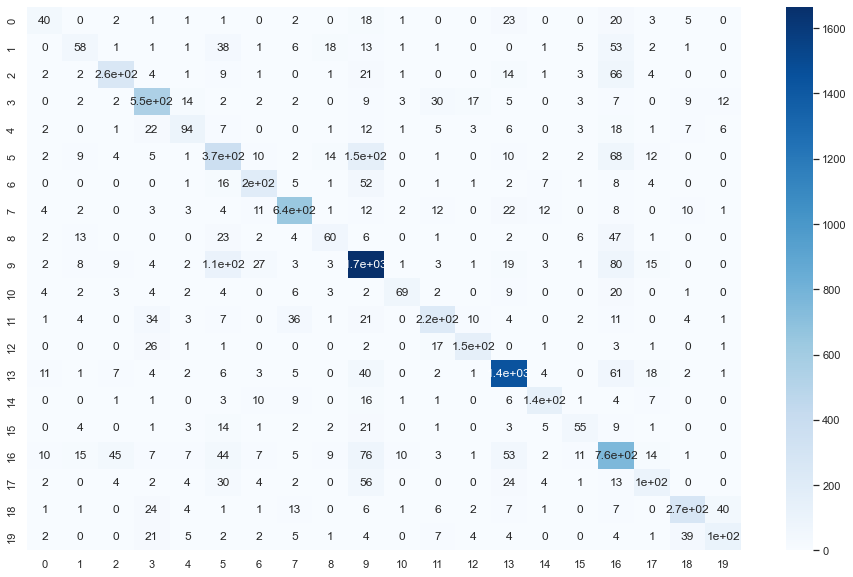

In [51]:
conf_mat = confusion_matrix(y_test_sm, lr_cv_sm.predict(x_test_sm))
sns.set(rc = {'figure.figsize':(16,10)})
sns.heatmap(conf_mat, annot=True, cmap="Blues")

So it seems they reduced our accuracy by 4%, but as we reduced the amount of features we have by 80%, this is a good trade off. Perhaps we can try our next option now.

### Option 5: Playing with testing/training sizes

One more thing we can do is increasing/decreasing the testing and training sizes we have used. Giving our algorithm more data to train on could result in better testing accuracy.

We'll do this for a range of training set sizes, from 60% all the way to 90% in increments of 5%.

In [52]:
# TAKES A WHILE

test_sizes = np.arange(.60, .95, .05)

train_scores = list()
test_scores = list()

for size in tqdm(test_sizes):
    x_train, x_test, y_train, y_test = train_test_split(df_pca, df['cuisine'], train_size=size, random_state=1, stratify=df['cuisine'])
    lr_cv = LogisticRegression().fit(x_train, y_train)
    
    train_scores.append(accuracy_score(y_train, lr_cv.predict(x_train)))
    test_scores.append(accuracy_score(y_test, lr_cv.predict(x_test)))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:32<00:00,  4.65s/it]


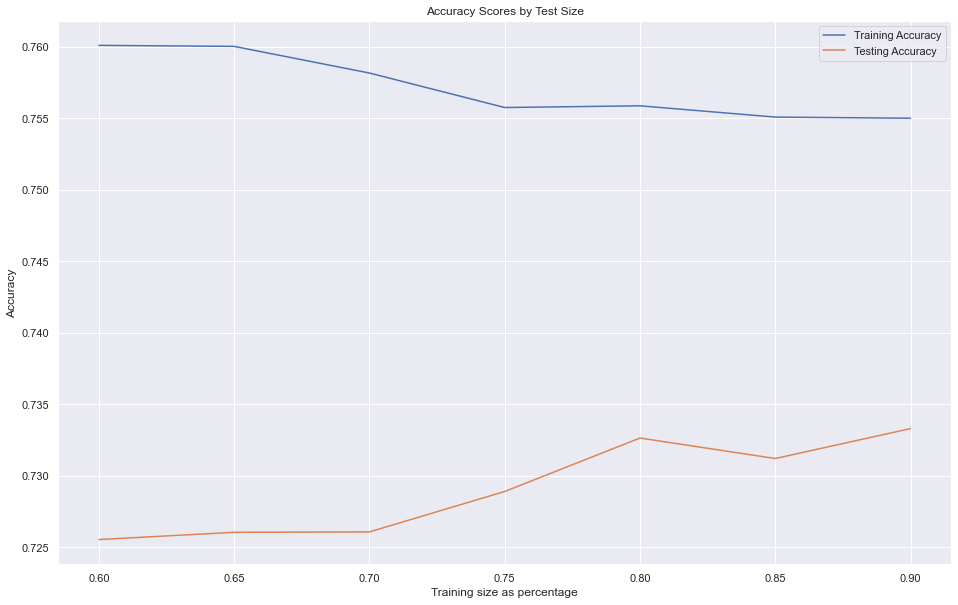

In [53]:
# plot lines
plt.plot(test_sizes, train_scores, label = "Training Accuracy")
plt.plot(test_sizes, test_scores, label = "Testing Accuracy")
plt.xlabel("Training size as percentage")
plt.ylabel("Accuracy")
plt.title("Accuracy Scores by Test Size")
plt.legend()
plt.show()

Looking at this graph, we can see that as we increase the number of training examples we give the algorithm, our training accuracy continues to climb. Conversely, our testing accuracy falls. This may be because our model is unable to generalize well to new data as it has overfit to our training data.

## Conclusion

We've done our best to classify cuisines using textual analysis, but it seems its still quite difficult to achieve a super high accuracy given the data we have. Often in machine learning, you'll encounter problems that you just can't solve to certain requirements such as a 90%+ accuracy. The data you're given may be lacking information, you may need to further clean your data, or the algorithm you employ may simply not work well with the use case. In this example, we tried many methods to process our data and increase accuracy, but only marginally.

The next steps could be to try an alternative algorithm, or find a way to extract more information from your data. Thanks for joining the ride and I hope you learned something today!